# 0.0 Imports


In [139]:
import pandas as pd
import numpy as np
import inflection 
import math
import seaborn as sns
import datetime
from IPython.display import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

from boruta import BorutaPy
from IPython.core.display import HTML

## 0.1 Help Function

In [196]:
def jupyter_settings():
        %matplotlib inline
        %pylab inline
        plt.style.use( 'bmh' )
        plt.rcParams['figure.figsize'] = [25, 12]
        plt.rcParams['font.size'] = 24
        display( HTML( '<style>.container { width:100% !important; }</style>') )
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        pd.set_option( 'display.expand_frame_repr', False )
        sns.set()
jupyter_settings()


def ml_error(model_name, y, yhat):
        mae = mean_absolute_error(y, yhat)
        mape = mean_absolute_percentage_error(y, yhat)
        rmse = np.sqrt(mean_squared_error(y, yhat))
        
        return pd.DataFrame({'Model Name': model_name,
                                'MAE': mae,
                                'MAPE': mape,
                                'RMSE': rmse}, index=[0])
        
def cross_validation(x_training, kfold, model_name, model, verbose=False):
        mae_list = []
        mape_list = []
        rmse_list = []
        for k in reversed(range ( 1, kfold+1)):
                print(f'Kfold Number {k}')
                # start and end date for validation
                validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
                validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

                #filtering dataset
                training = x_training[x_training['date'] < validation_start_date]
                validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

                #training and validation dataset
                #training
                xtraining  = training.drop(['date', 'sales'], axis=1)
                ytraining = training['sales']

                #validation
                xvalidation  = validation.drop(['date', 'sales' ], axis=1)
                yvalidation  = validation['sales']

                #model
                m = model.fit(xtraining, ytraining)

                #prediction
                yhat = m.predict(xvalidation)

                #performance
                m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

                #store performance of each kfold iteration
                mae_list.append(m_result['MAE'])
                mape_list.append(m_result['MAPE'])
                rmse_list.append(m_result['RMSE'])

        return pd.DataFrame(
        {   'Model Name': model_name,
        'MAE CV': f'{np.round(np.mean(mae_list), 3).astype(str)} (+/-) {np.round(np.std(mae_list), 3).astype(str)}',
        'MAPE CV': f'{np.round(np.mean(mape_list), 3).astype(str)} (+/-) {np.round(np.std(mape_list), 3).astype(str)}',
        'RMSE CV': f'{np.round(np.mean(rmse_list), 3).astype(str)} (+/-) {np.round(np.std(rmse_list), 3).astype(str)}',
        }, index=[0])
        




%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# from ydata_profiling import ProfileReport
# from ydata_profiling.report.presentation.flavours.widget.alerts import WidgetAlerts
# from ipywidgets import HTML, Button, widgets
# profile = ProfileReport(df_raw, title="Profiling Report")
# profile.to_file("ds_producao.html")


# 1.0 Descrição dos dados

In [4]:
df1 = df_raw.copy()

## CRIA UM RESUMO BEM COMPLETO DO DATAFRAME!!!!!!
# from ydata_profiling import ProfileReport
# report = ProfileReport(df1, title='My Data')
# report.to_file("my_report.html")

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print(f'Numero de linhas {df1.shape[0]}')
print(f'Numero de Colunas {df1.shape[1]}')

Numero de linhas 1017209
Numero de Colunas 18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preencher NA

In [9]:
# competition_distance              2642

df1['competition_distance'] = (df1['competition_distance']
                                .apply(lambda x: 200000 if math.isnan(x) else x))

    # competition_open_since_month    323348
df1['competition_open_since_month'] = (df1.apply( lambda x: x['date'].month
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1))
# competition_open_since_year     323348

df1['competition_open_since_year'] = (df1.apply( lambda x: x['date'].year
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1))

# promo2_since_week               508031
df1['promo2_since_week'] = (df1.apply( lambda x: x['date'].week
                                                if math.isnan(x['promo2_since_week'])
                                                else x['promo2_since_week'], axis=1))

# promo2_since_year               508031
df1['promo2_since_year'] = (df1.apply( lambda x: x['date'].year
                                        if math.isnan(x['promo2_since_year'])
                                        else x['promo2_since_year'], axis=1))
# promo_interval                  508031


month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May',
                6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = (df1[['promo_interval', 'month_map']].apply(lambda x :0 if x['promo_interval'] == 0 
        else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1))
df1.sample(10).T


,670727,1014642,60432,287237,897680,522857,408242,600269,842849,290444
store,283,778,223,440,891,708,910,70,695,925
day_of_week,4,4,7,5,4,4,2,4,4,2
date,2013-11-07 00:00:00,2013-01-03 00:00:00,2015-06-07 00:00:00,2014-11-07 00:00:00,2013-04-18 00:00:00,2014-03-20 00:00:00,2014-07-01 00:00:00,2014-01-09 00:00:00,2013-06-06 00:00:00,2014-11-04 00:00:00
sales,7089,4600,0,6344,5770,4068,6389,6939,5529,8123
customers,733,710,0,684,980,426,625,694,617,1179
open,1,1,0,1,1,1,1,1,1,1
promo,1,0,0,1,0,1,1,1,1,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,1,0,0,0,0,0,0,0,0
store_type,a,a,d,d,a,c,d,c,a,c


## 1.5 Change Types

In [10]:

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descrição Estatística

In [11]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

cat_attributes.sample(10)

,state_holiday,store_type,assortment,promo_interval,month_map
196694,0,d,c,0,Fev
752263,0,d,c,"Jan,Apr,Jul,Oct",Aug
662194,0,a,a,"Feb,May,Aug,Nov",Nov
479169,0,a,a,"Feb,May,Aug,Nov",Apr
500981,0,a,a,"Jan,Apr,Jul,Oct",Apr
32606,0,a,a,"Jan,Apr,Jul,Oct",Jul
372228,0,a,c,"Jan,Apr,Jul,Oct",Aug
137592,0,a,c,0,Mar
378712,0,b,b,0,Aug
72549,0,d,c,0,May


### 1.7.1 Numerical Attributes

In [12]:
#Tendência central = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersão = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


## Passos mais simples para tirar os dados acima:
# ct10 = pd.DataFrame(num_attributes.mean()).T
# ct11 = pd.DataFrame(num_attributes.median()).T
# d12 = pd.DataFrame(num_attributes.max() - num_attributes.min()).T
# m1 = pd.concat([ct10, ct11, d12]).T.reset_index()
# print(m1)



,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos categóricos

C:\Users\junic\AppData\Local\Temp\ipykernel_14996\3447266477.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='state_holiday', y='sales', data=aux1, palette='pastel')
C:\Users\junic\AppData\Local\Temp\ipykernel_14996\3447266477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='store_type', y='sales', data=aux1, palette='Set2')
C:\Users\junic\AppData\Local\Temp\ipykernel_14996\3447266477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='assortment', y='sales', data=aux1, palette='flare')


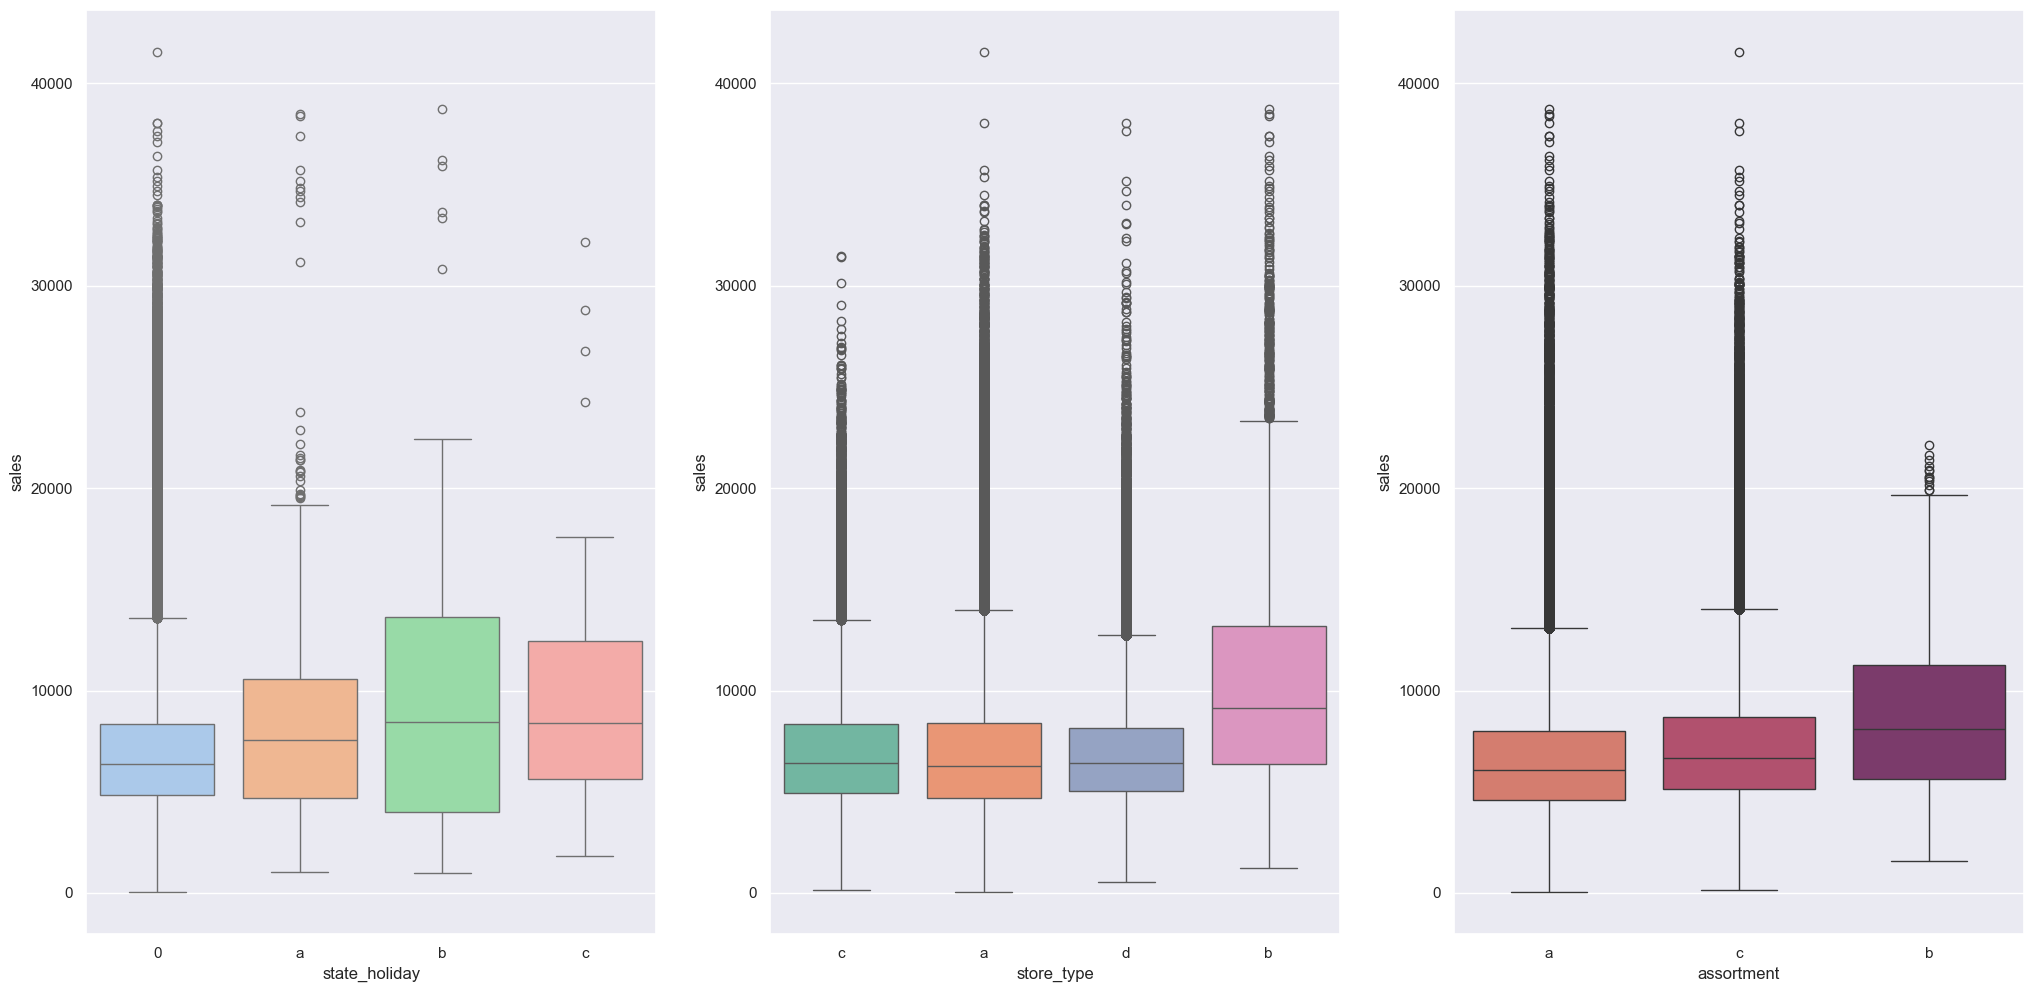

In [13]:
cat_attributes.apply(lambda x : x.unique().shape[0])
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, palette='pastel')
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, palette='Set2')
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, palette='flare')
plt.show()

# 2.0 Feature Engineering

## 2.1 Mapa Mental de Hipoteses

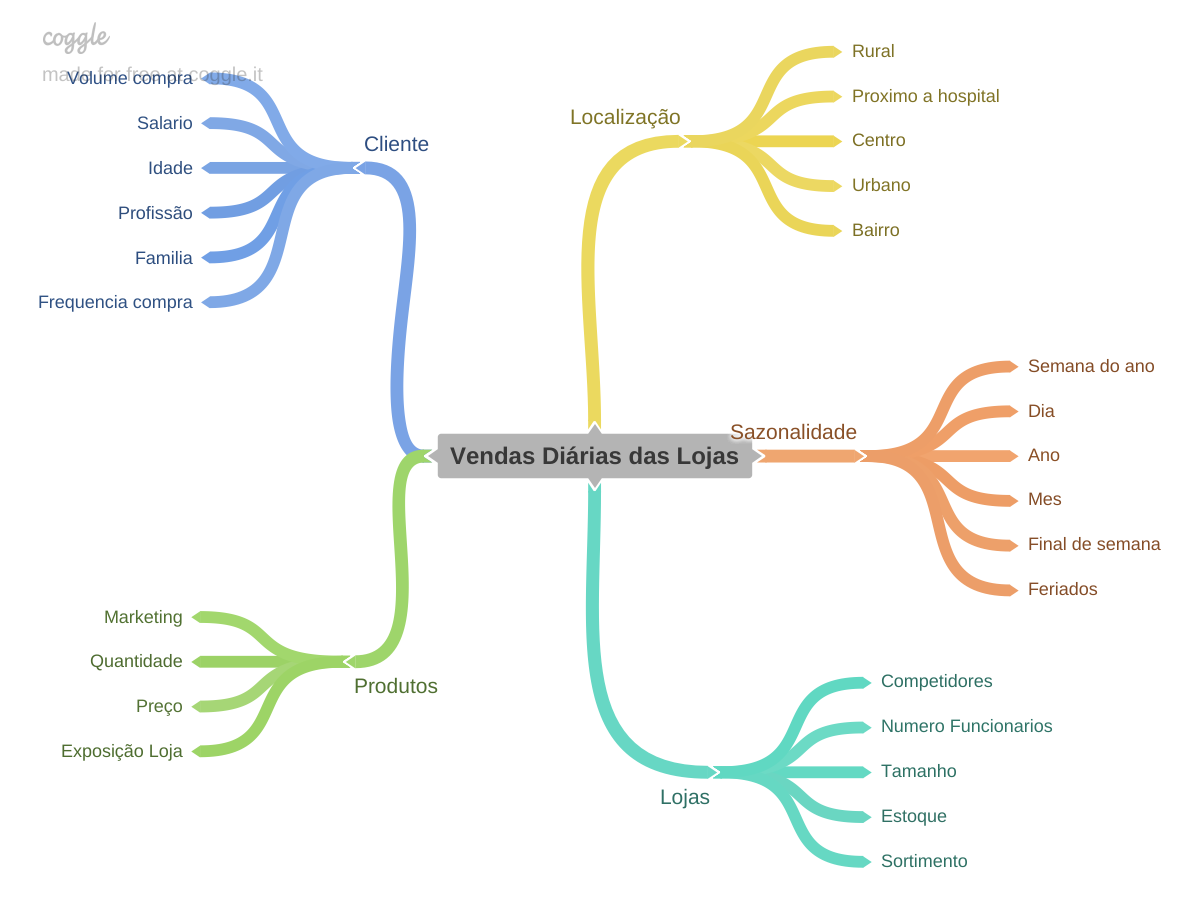

In [14]:
Image ('Vendas_Diarias_das_Lojas_mindmap.png')

## 2.2 Criacao das Hipoteses

In [15]:
df2 = df1.copy()
df2.sample(10).T

,368933,946613,737055,964332,683988,40101,793704,362351,408295,754735
store,862,764,826,643,164,1077,610,819,969,666
day_of_week,2,2,1,7,6,5,6,2,2,6
date,2014-08-12 00:00:00,2013-03-05 00:00:00,2013-09-09 00:00:00,2013-02-17 00:00:00,2013-10-26 00:00:00,2015-06-26 00:00:00,2013-07-20 00:00:00,2014-08-19 00:00:00,2014-07-01 00:00:00,2013-08-24 00:00:00
sales,7426,2176,11627,0,3015,3901,2993,7069,4625,6022
customers,979,270,1016,0,367,491,373,585,740,614
open,1,1,1,0,1,1,1,1,1,1
promo,0,1,1,0,0,0,0,1,1,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,1,0,0,0,0,0,0,1,0,0
store_type,a,a,a,a,a,a,a,a,a,c


### 2.2.1 Hipoteses Loja

1. Lojas com maior quadro de funcionarios deveriam vender
2. Lojas com maior estoque deveriam vender mais 
3. Lojas com maior porte deveriam vender mais
4. Lojas com maior sortimento deveriam vender mais
5. Lojas com maior sortimento deveriam vender mais



### 2.2.2 Hipoteses Produto


1. Lojas que investem mais em marketing deeveriam vender mais
2. Lojas que expoe mais produtos nas vitrinas deveriam vender mais
3. Lojas que tem preços menores deveriam vender mais
4. Lojas que tem mais promoções deveriam vender mais

### 2.2.3 Hipoteses Tempo

1. Lojas que tem mais feriados deveriam vender menos
2. Lojas que abrem nos primeiros 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais


## 2.3 Lista final de hipoteses

4. Lojas com maior sortimento deveriam vender mais


## 2.4 Feature Engineering

In [27]:

# year
df2 ['year'] = df2['date'].dt.year

# month
df2 ['month'] = df2['date'].dt.month
# day
df2 ['day'] = df2['date'].dt.day
# week of year
df2 ['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year']
                                        .astype(str) + '-' + df2['competition_open_since_month']
                                        .astype(str) + '-1', format='%Y-%m-%d')
# Convertendo para o formato datetime
df2['competition_since'] = pd.to_datetime(df2['competition_since'])
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).dt.days / 30).astype(int)

#df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
    # Criando a coluna 'promo_since' a partir de 'promo2_since_year' e 'promo2_since_week'
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'

    # Convertendo a coluna 'promo_since' para datetime
df2['promo_since'] = pd.to_datetime(df2['promo_since'], format='%Y-%W-%w')

    # Subtraindo 7 dias para ajustar a data para o início da semana anterior
df2['promo_since'] = df2['promo_since'] - pd.to_timedelta(7, unit='d')
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
#alterando os valores de a, b e c para a notação basic, extra e extended
df1['assortment'] = df1['assortment'].replace({'^a$': 'basic', '^b$': 'extra', '^c$': 'extended'}, regex=True)



# state holiday
df2['state_holiday'] = (df2['state_holiday']
                        .replace({'^a$': 'public_holiday', '^b$': 'easter_holiday', '^c$': 'christimas', '0':'regular_day'}, regex=True))

df2.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
343090,148,1,2014-09-08,8383,824,1,0,regular_day,0,a,a,2090.0,12,2008,0,37,2014,0,Sep,0,2014,9,8,37,2014-36,2008-12-01,70,2014-09-08,0
377694,160,6,2014-08-02,5573,552,1,0,regular_day,1,d,c,17110.0,11,2005,0,31,2014,0,Aug,0,2014,8,2,31,2014-30,2005-11-01,106,2014-07-28,0
730984,330,6,2013-09-14,3703,451,1,0,regular_day,0,a,c,370.0,9,2013,1,22,2012,"Mar,Jun,Sept,Dec",Sep,0,2013,9,14,37,2013-36,2013-09-01,0,2012-05-21,68
1004604,775,6,2013-01-12,7458,589,1,0,regular_day,0,d,c,6970.0,12,2005,1,22,2011,"Jan,Apr,Jul,Oct",Jan,1,2013,1,12,2,2013-01,2005-12-01,86,2011-05-23,85
523096,947,4,2014-03-20,7425,1050,1,1,regular_day,0,a,a,460.0,3,2014,1,13,2010,"Jan,Apr,Jul,Oct",Mar,0,2014,3,20,12,2014-11,2014-03-01,0,2010-03-22,208
108478,324,6,2015-04-25,1941,265,1,0,regular_day,0,a,a,13140.0,4,2015,1,14,2011,"Jan,Apr,Jul,Oct",Apr,1,2015,4,25,17,2015-16,2015-04-01,0,2011-03-28,212
357715,864,7,2014-08-24,0,0,0,0,regular_day,0,a,a,1020.0,10,2012,1,45,2009,"Feb,May,Aug,Nov",Aug,1,2014,8,24,34,2014-33,2012-10-01,23,2009-11-02,250
798726,57,1,2013-07-15,20796,1668,1,1,regular_day,1,d,c,420.0,6,2014,0,29,2013,0,Jul,0,2013,7,15,29,2013-28,2014-06-01,-10,2013-07-15,0
133731,1047,5,2015-04-03,0,0,0,1,easter_holiday,1,a,a,3750.0,4,2015,1,45,2009,"Feb,May,Aug,Nov",Apr,0,2015,4,3,14,2015-13,2015-04-01,0,2009-11-02,282
741708,1019,4,2013-09-05,5914,606,1,0,regular_day,1,d,c,2740.0,7,2014,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2013,9,5,36,2013-35,2014-07-01,-9,2010-03-22,180


# 3.0 Filtragem de Variáveis

In [17]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [18]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 3.2 Selecao das Colunas

In [19]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, errors='ignore', axis=1)
df3.sample(10)


,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
875299,810,3,2013-05-08,7010,0,regular_day,0,d,c,9640.0,11,2013,0,19,2013,0,2013,5,8,19,2013-18,2013-11-01,-5,2013-05-06,0
732031,262,5,2013-09-13,20289,1,regular_day,0,b,a,1180.0,5,2013,0,37,2013,0,2013,9,13,37,2013-36,2013-05-01,4,2013-09-09,0
391559,1078,6,2014-07-19,5100,0,regular_day,0,d,c,670.0,7,2014,1,40,2011,1,2014,7,19,29,2014-28,2014-07-01,0,2011-09-26,146
517571,997,2,2014-03-25,3896,0,regular_day,0,d,c,5840.0,7,2010,1,37,2009,0,2014,3,25,13,2014-12,2010-07-01,45,2009-09-07,237
421885,86,3,2014-06-18,6213,1,regular_day,0,a,a,480.0,2,2005,1,31,2013,0,2014,6,18,25,2014-24,2005-02-01,114,2013-07-29,46
569176,197,4,2014-02-06,7201,1,regular_day,0,c,a,4210.0,3,2015,0,6,2014,0,2014,2,6,6,2014-05,2015-03-01,-12,2014-02-03,0
169151,787,1,2015-03-02,14665,1,regular_day,0,c,c,3210.0,6,2009,0,10,2015,0,2015,3,2,10,2015-09,2009-06-01,70,2015-03-02,0
701963,299,4,2013-10-10,6471,1,regular_day,1,d,c,38630.0,9,2012,0,41,2013,0,2013,10,10,41,2013-40,2012-09-01,13,2013-10-07,0
369160,11,1,2014-08-11,7431,0,regular_day,1,a,c,960.0,11,2011,1,1,2012,0,2014,8,11,33,2014-32,2011-11-01,33,2011-12-26,137
902528,164,6,2013-04-13,4225,0,regular_day,0,a,a,1160.0,9,2005,1,13,2010,1,2013,4,13,15,2013-14,2005-09-01,92,2010-03-22,159


# 4.0 Analise Exploratoria dos Dados

In [28]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response variable

<Axes: xlabel='sales', ylabel='Count'>

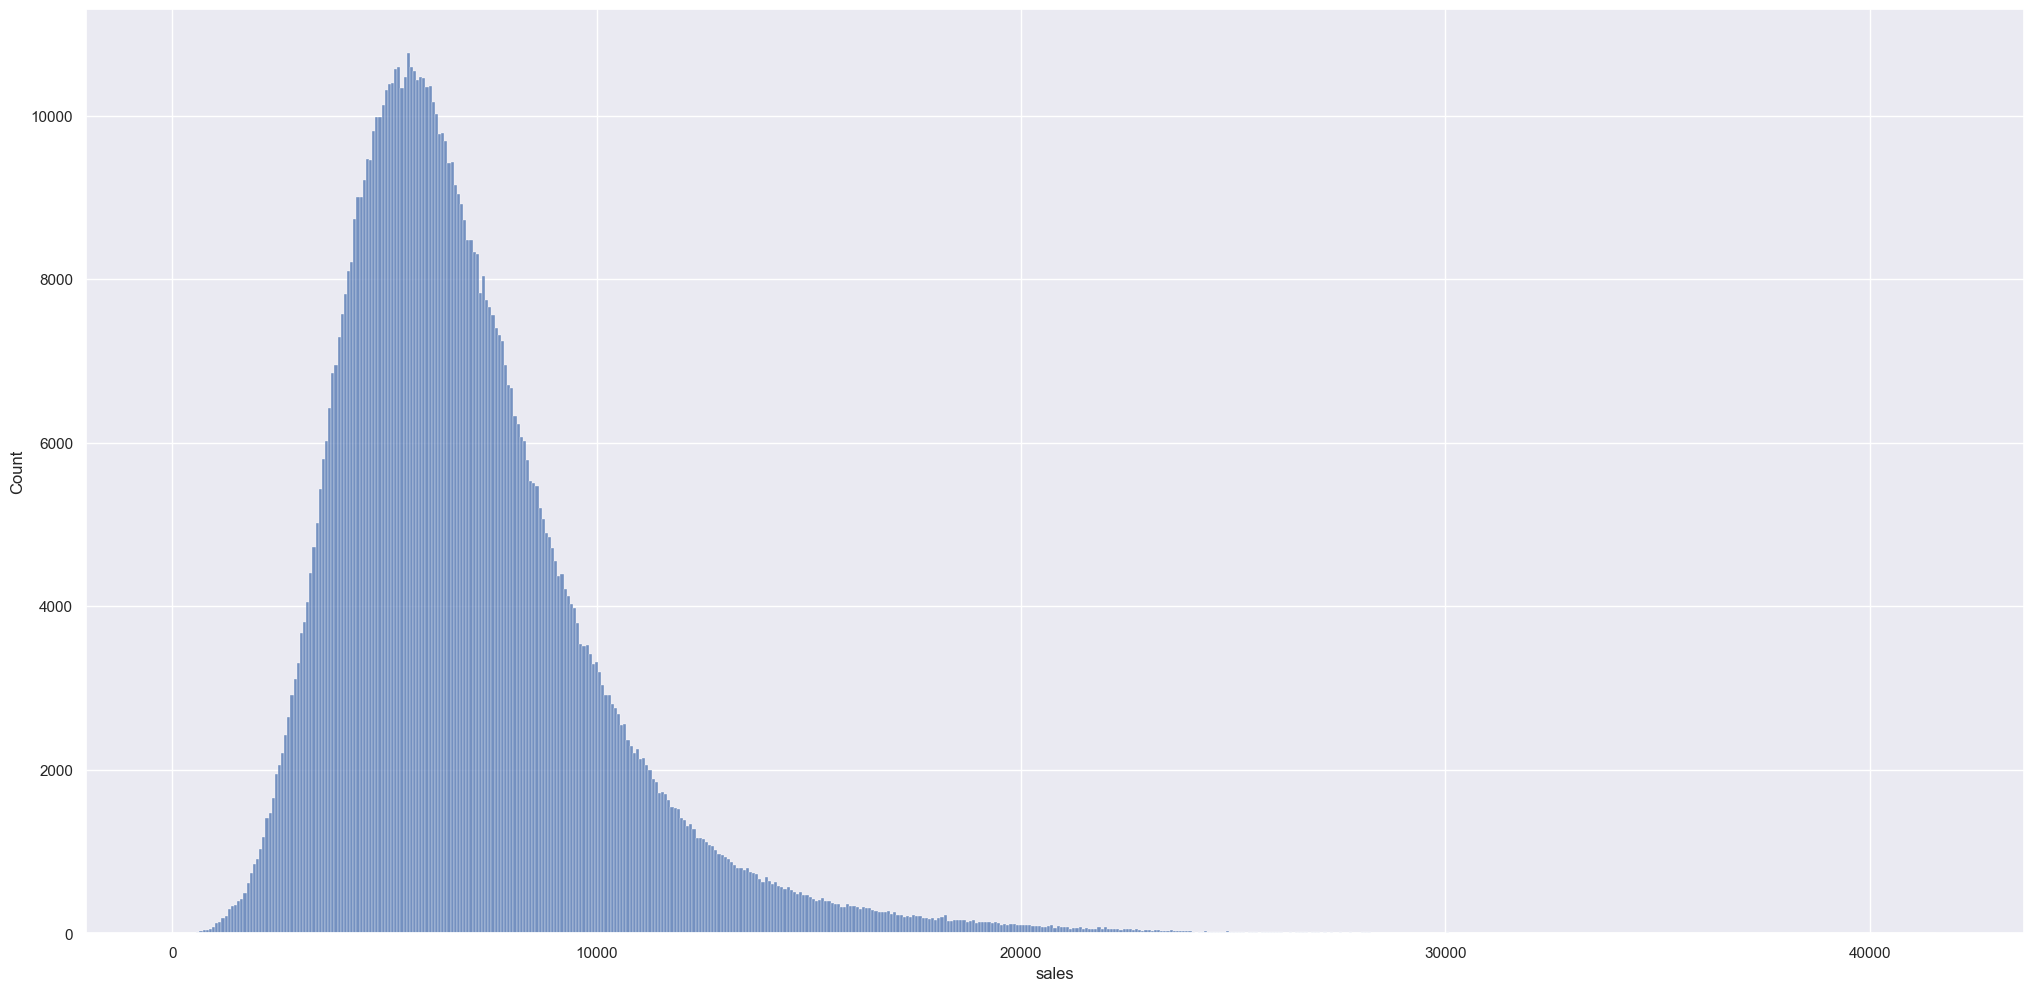

In [29]:
sns.histplot(df4['sales'])

### 4.1.2 Numerical variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

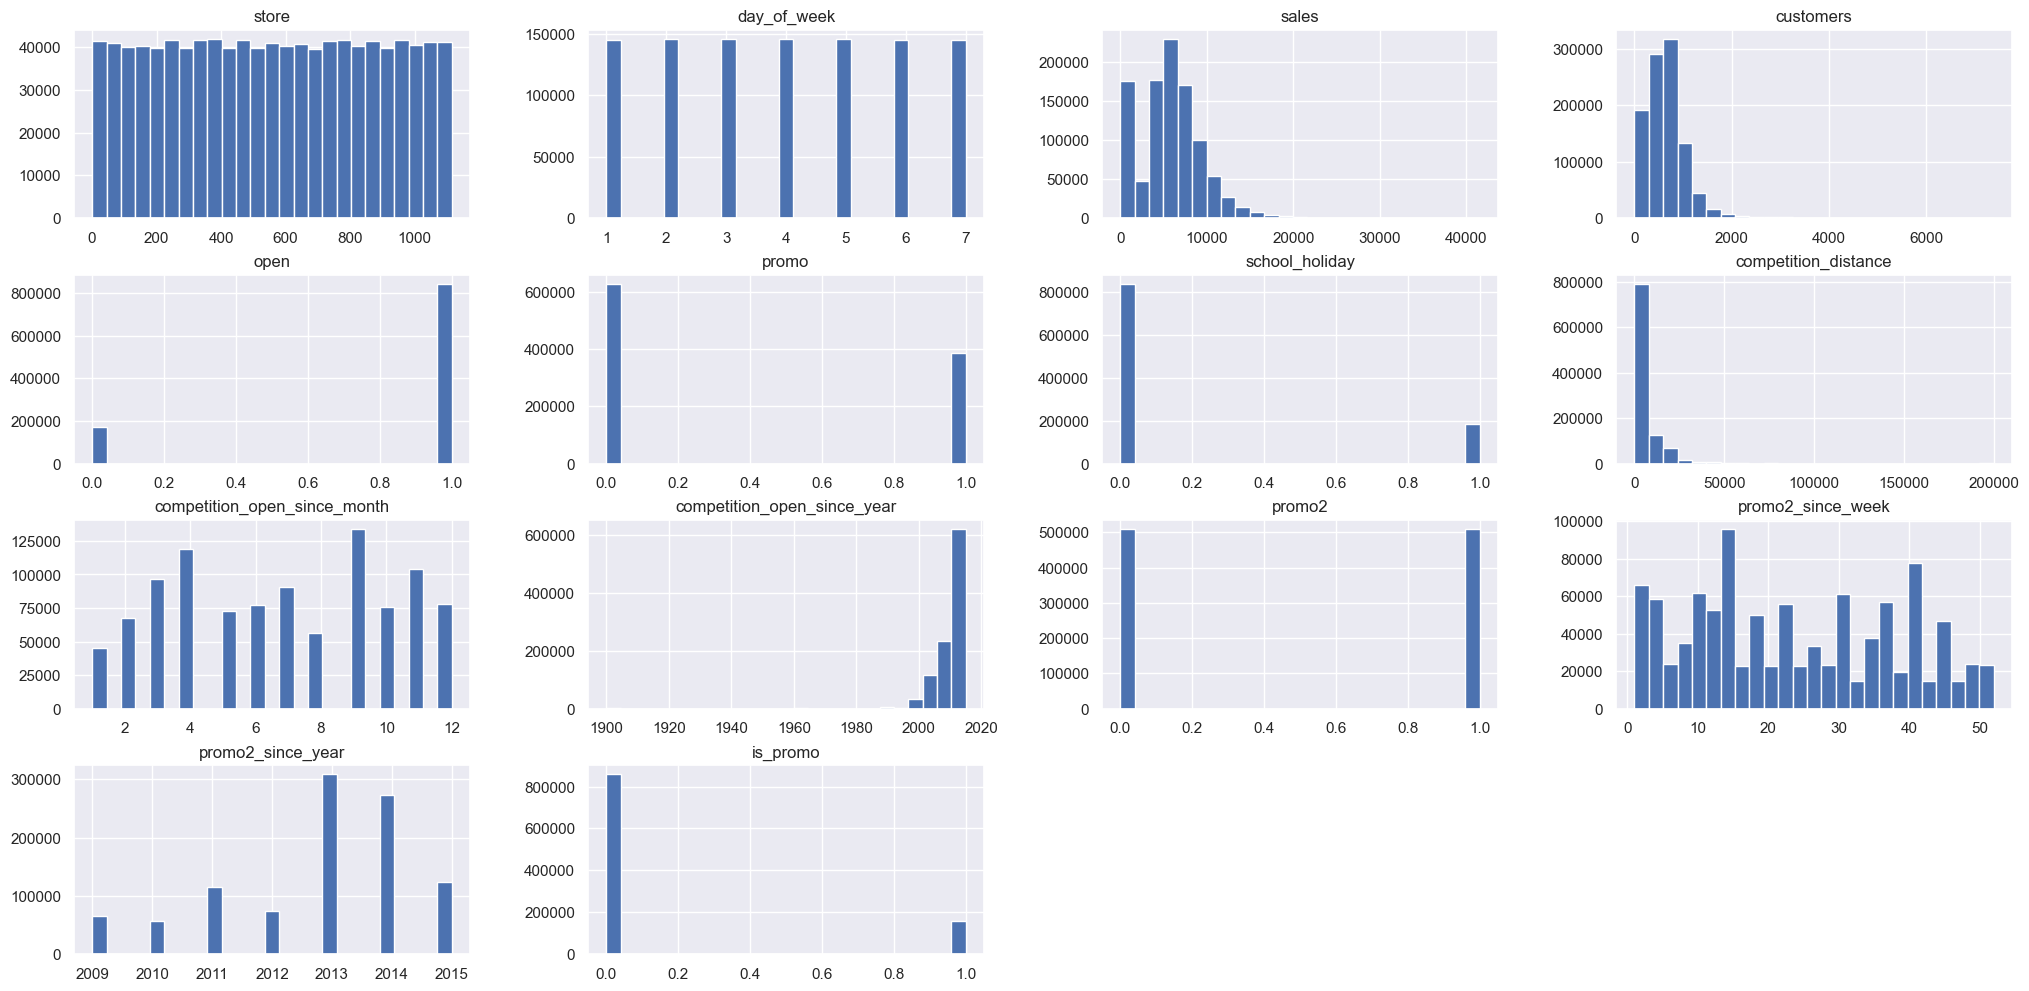

In [30]:
num_attributes.hist(bins=25)

### 4.1.3 Categorial variable

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


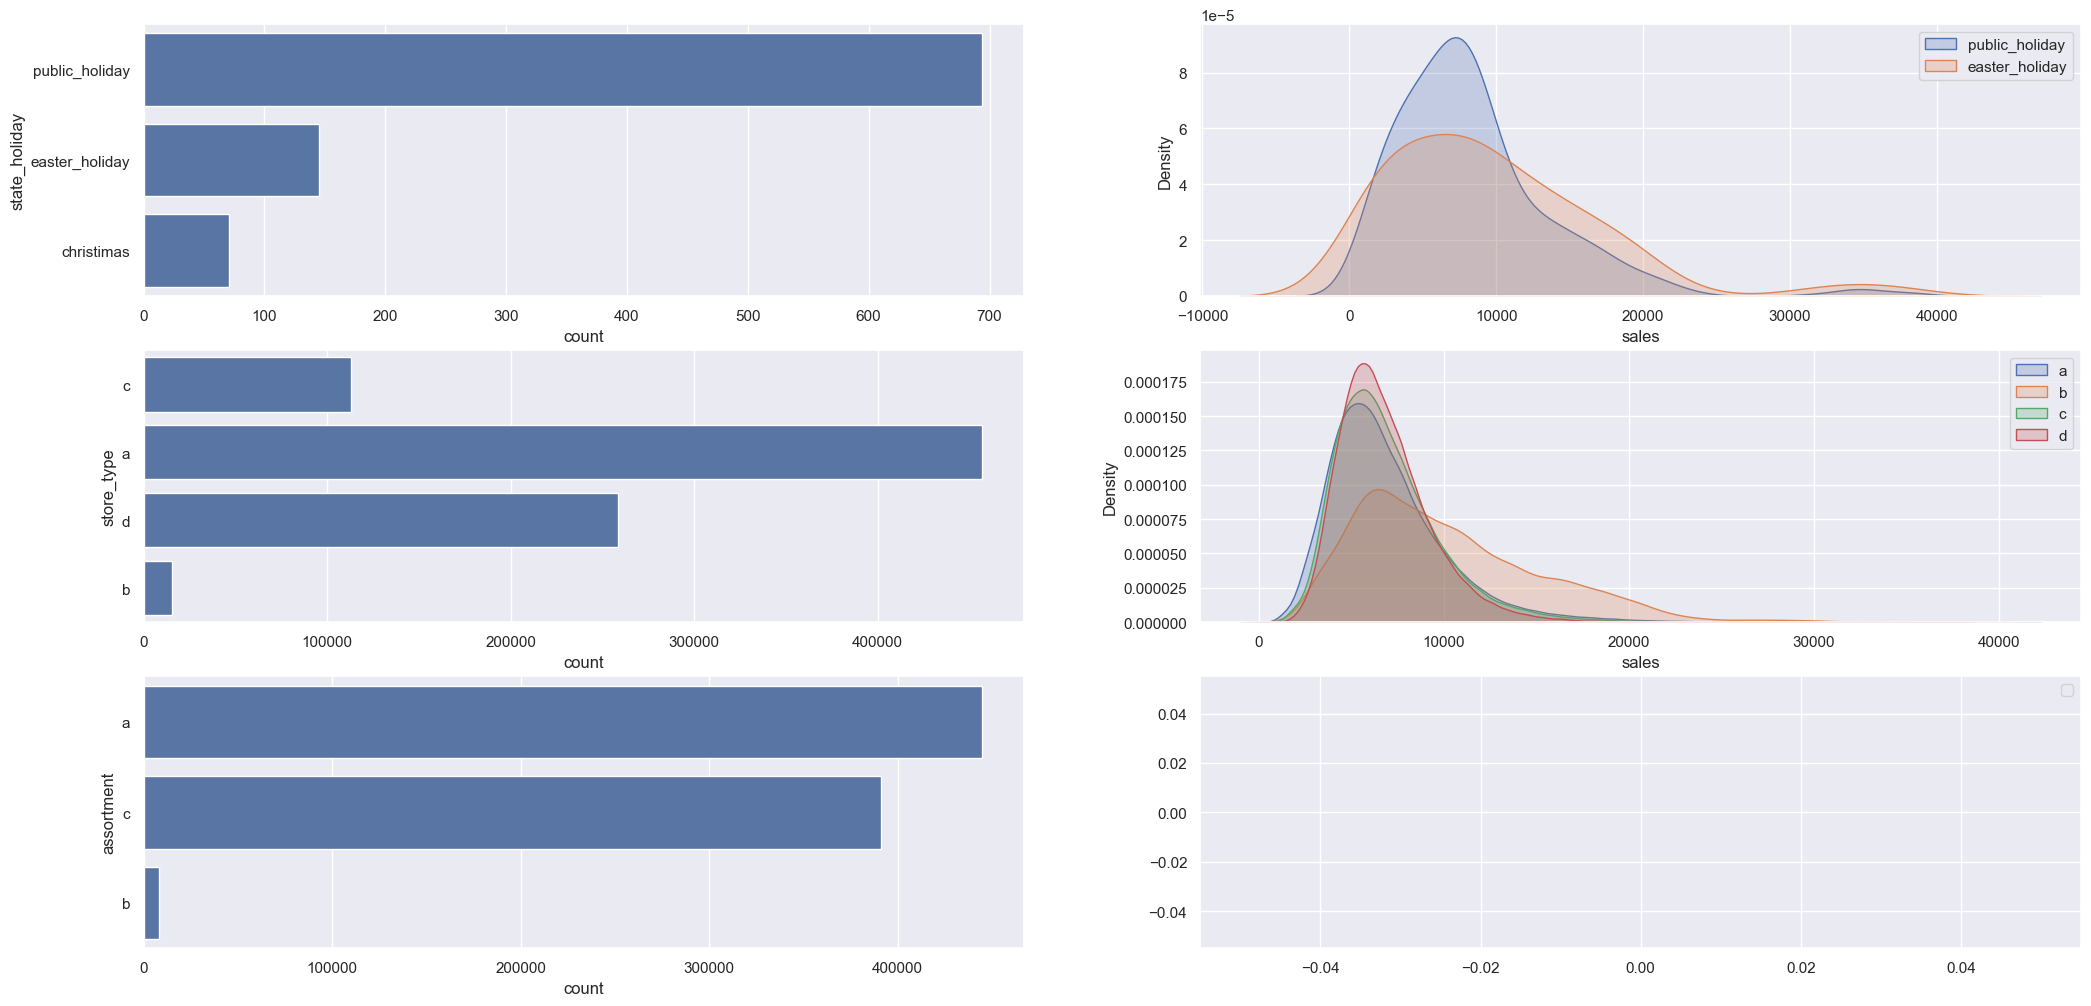

In [23]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True )
plt.legend()
#store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )
plt.legend()
# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.legend()
plt.show()


## 4.2 Analise Bivariada

### 4.2.1 Lojas com maior sortimento vendem mais

In [24]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

TypeError: no numeric data to plot

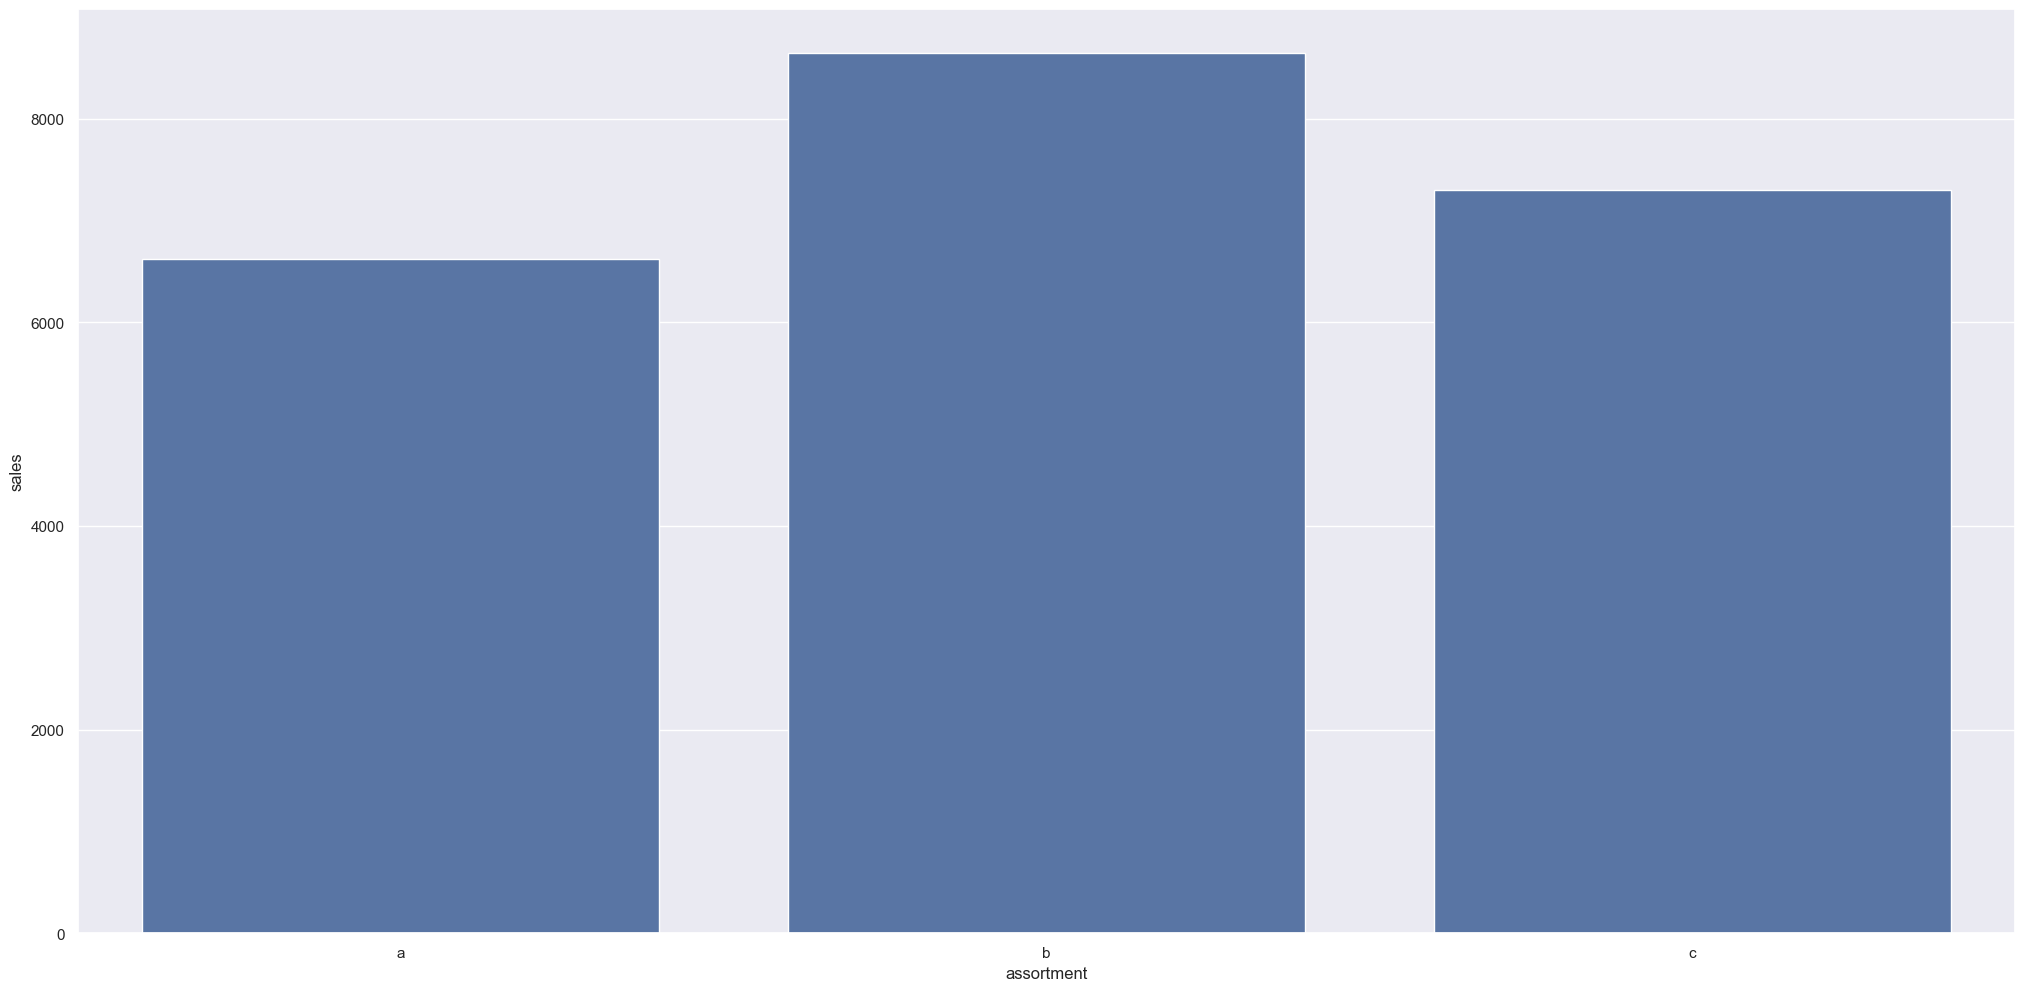

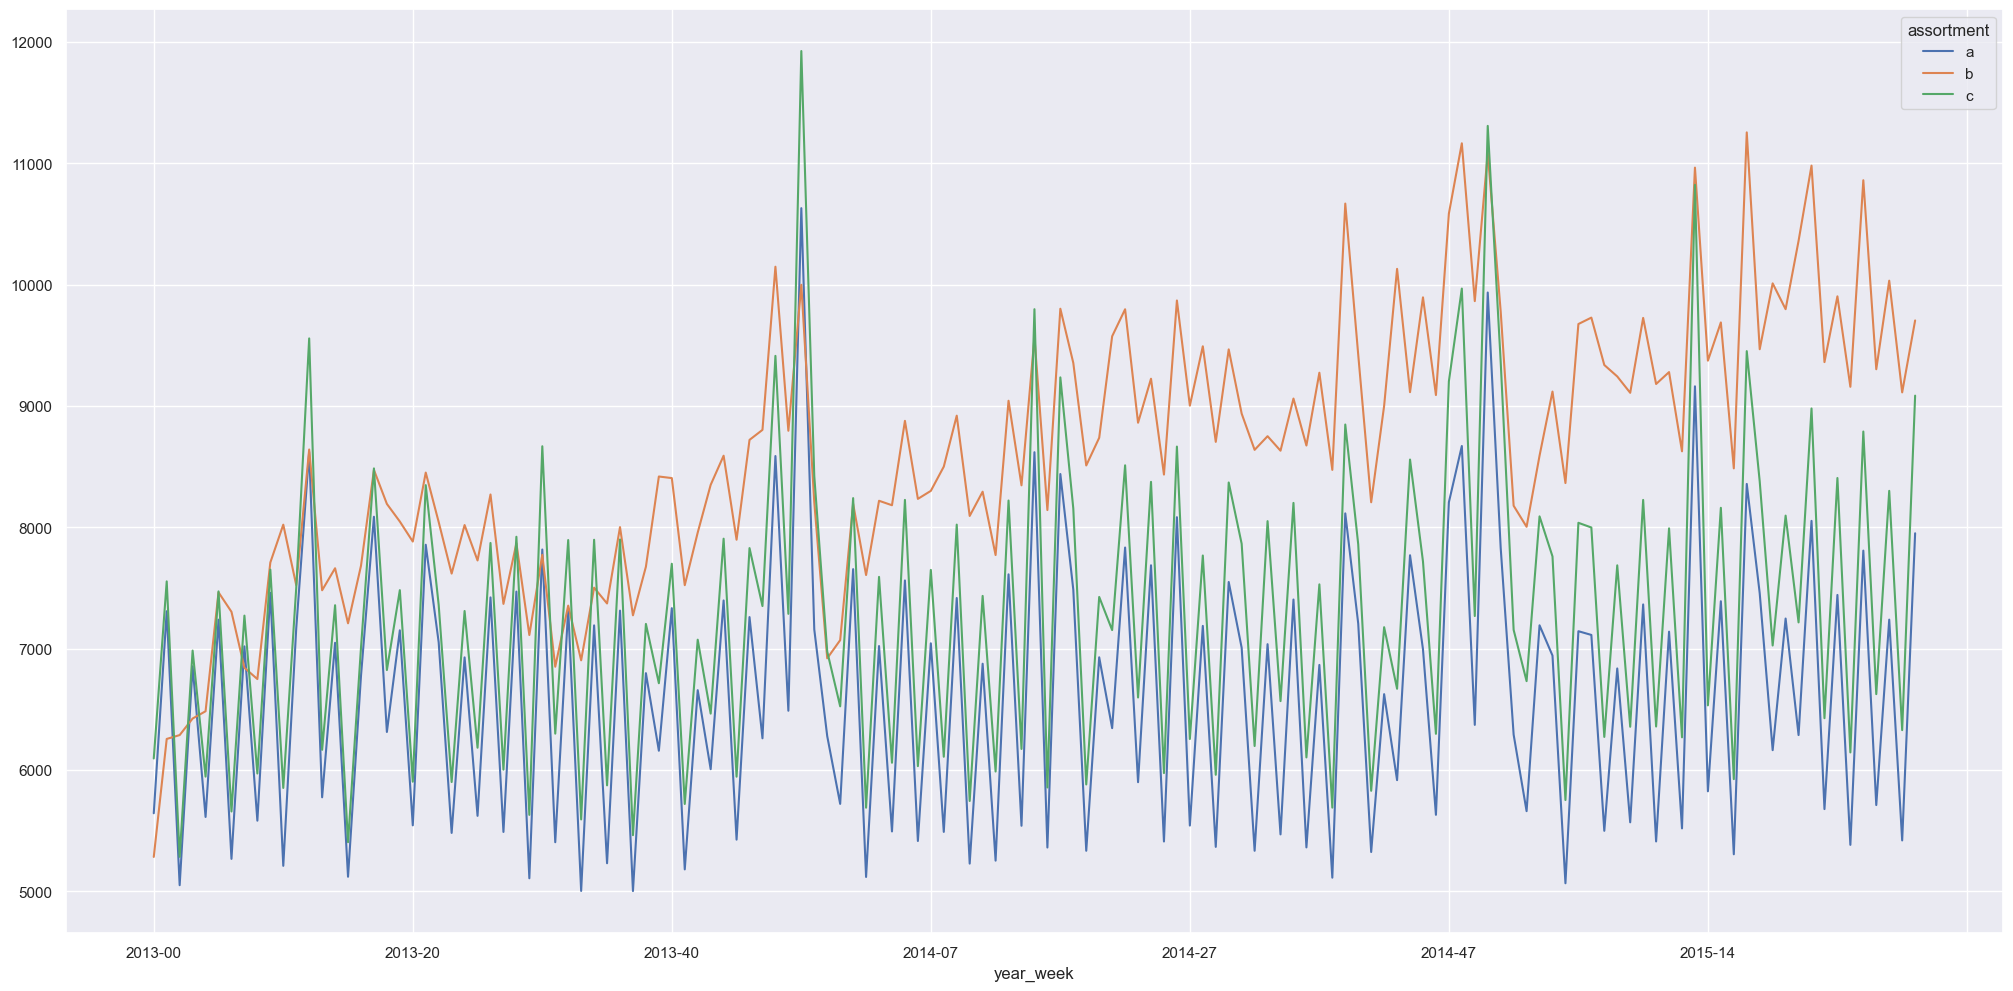

In [25]:
#ERRADO!!!!

aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()
contagem_valores = df4['assortment'].value_counts()
contagem_valores

### 4.2.2 Lojas com competidores mais próximos deveriam vender menos

C:\Users\junic\AppData\Local\Temp\ipykernel_15984\4280652352.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
c:\Users\junic\OneDrive\Documentos\Comunidade DS\repos\ds_em_producao\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\junic\OneDrive\Documentos\Comunidade DS\repos\ds_em_producao\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in futu

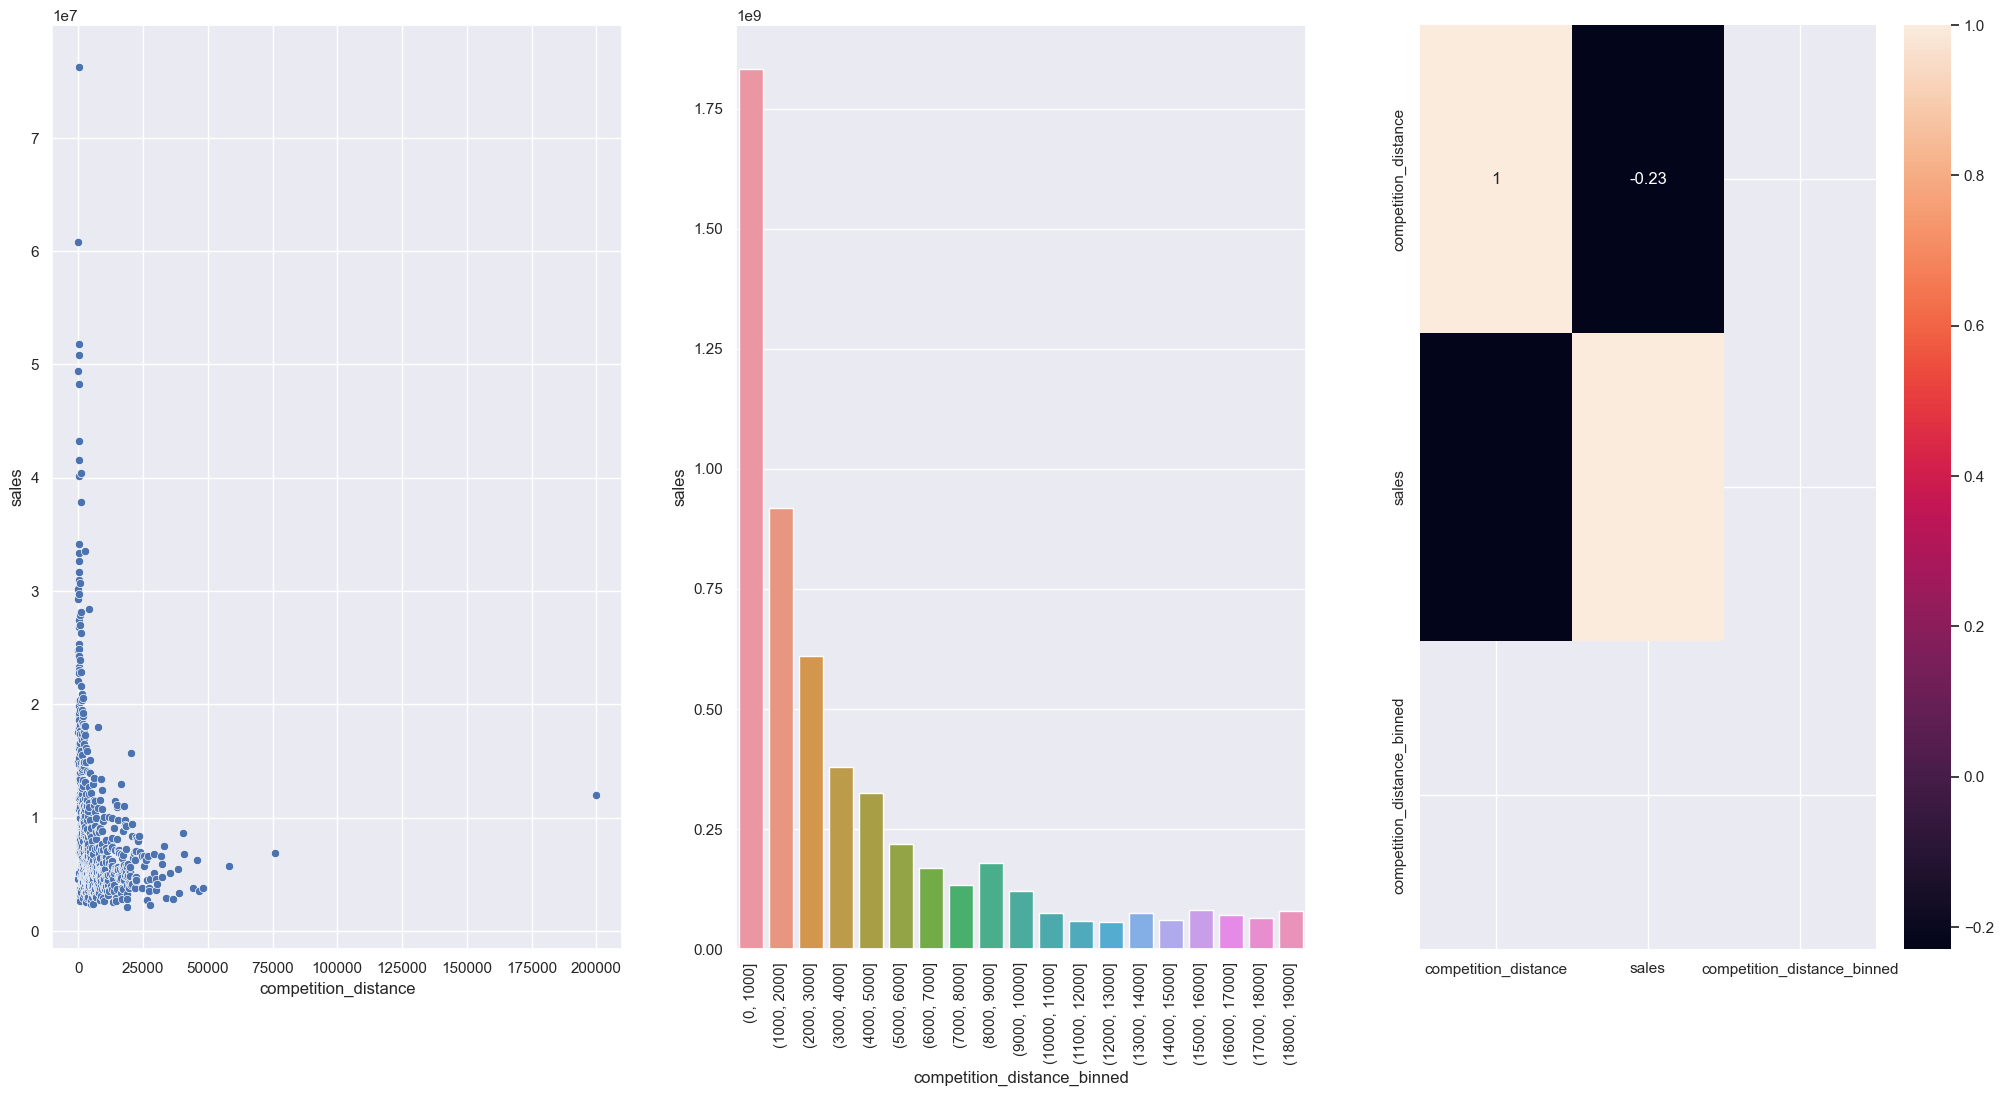

In [ ]:
#ERRADO!!!!

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 3 )
def convert_to_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

# Aplicar a função de conversão para todas as células do DataFrame
aux1_numeric = aux1.map(convert_to_float)
sns.heatmap( aux1_numeric.corr( method='pearson' ), annot=True );


### 4.2.3 Lojas com competidores há mais tempo deveriam vender mais

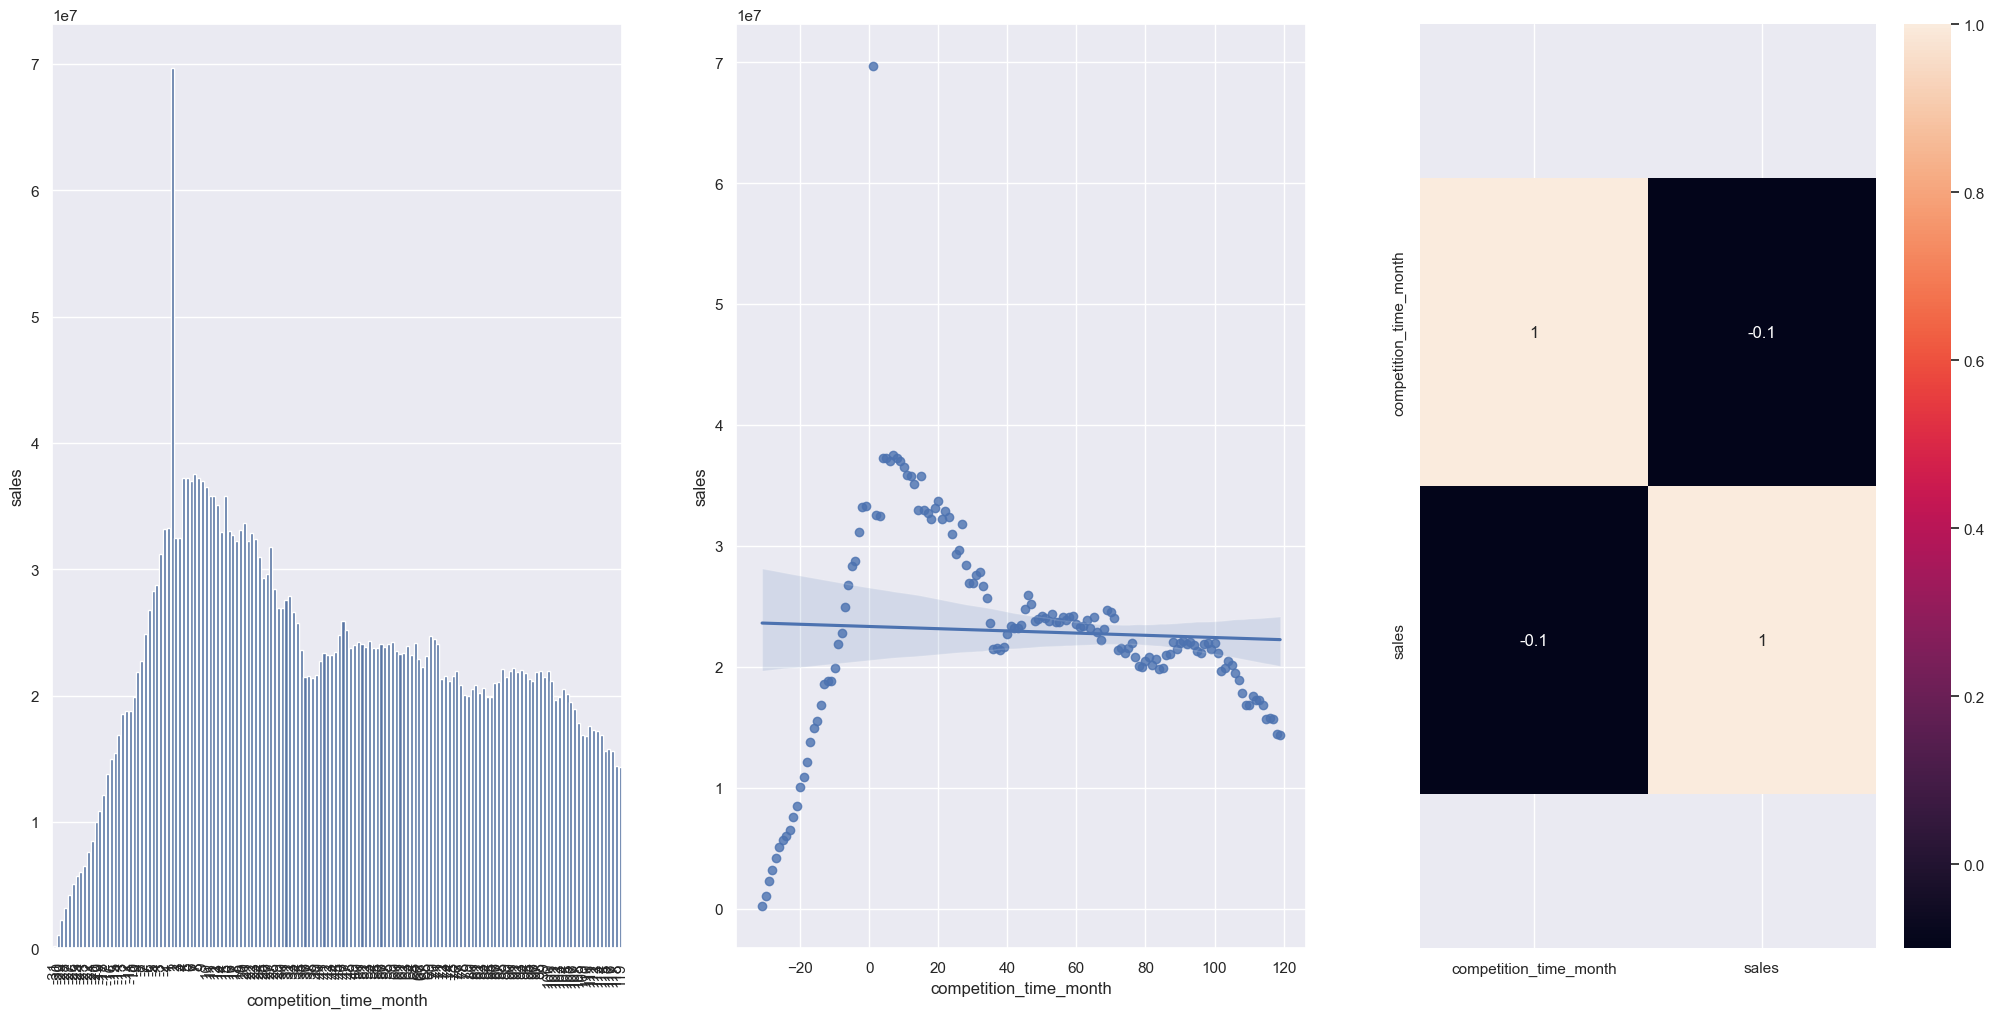

In [ ]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


### 4.2.4 Lojas com promoções ativas por mais tempo deveriam vender mais

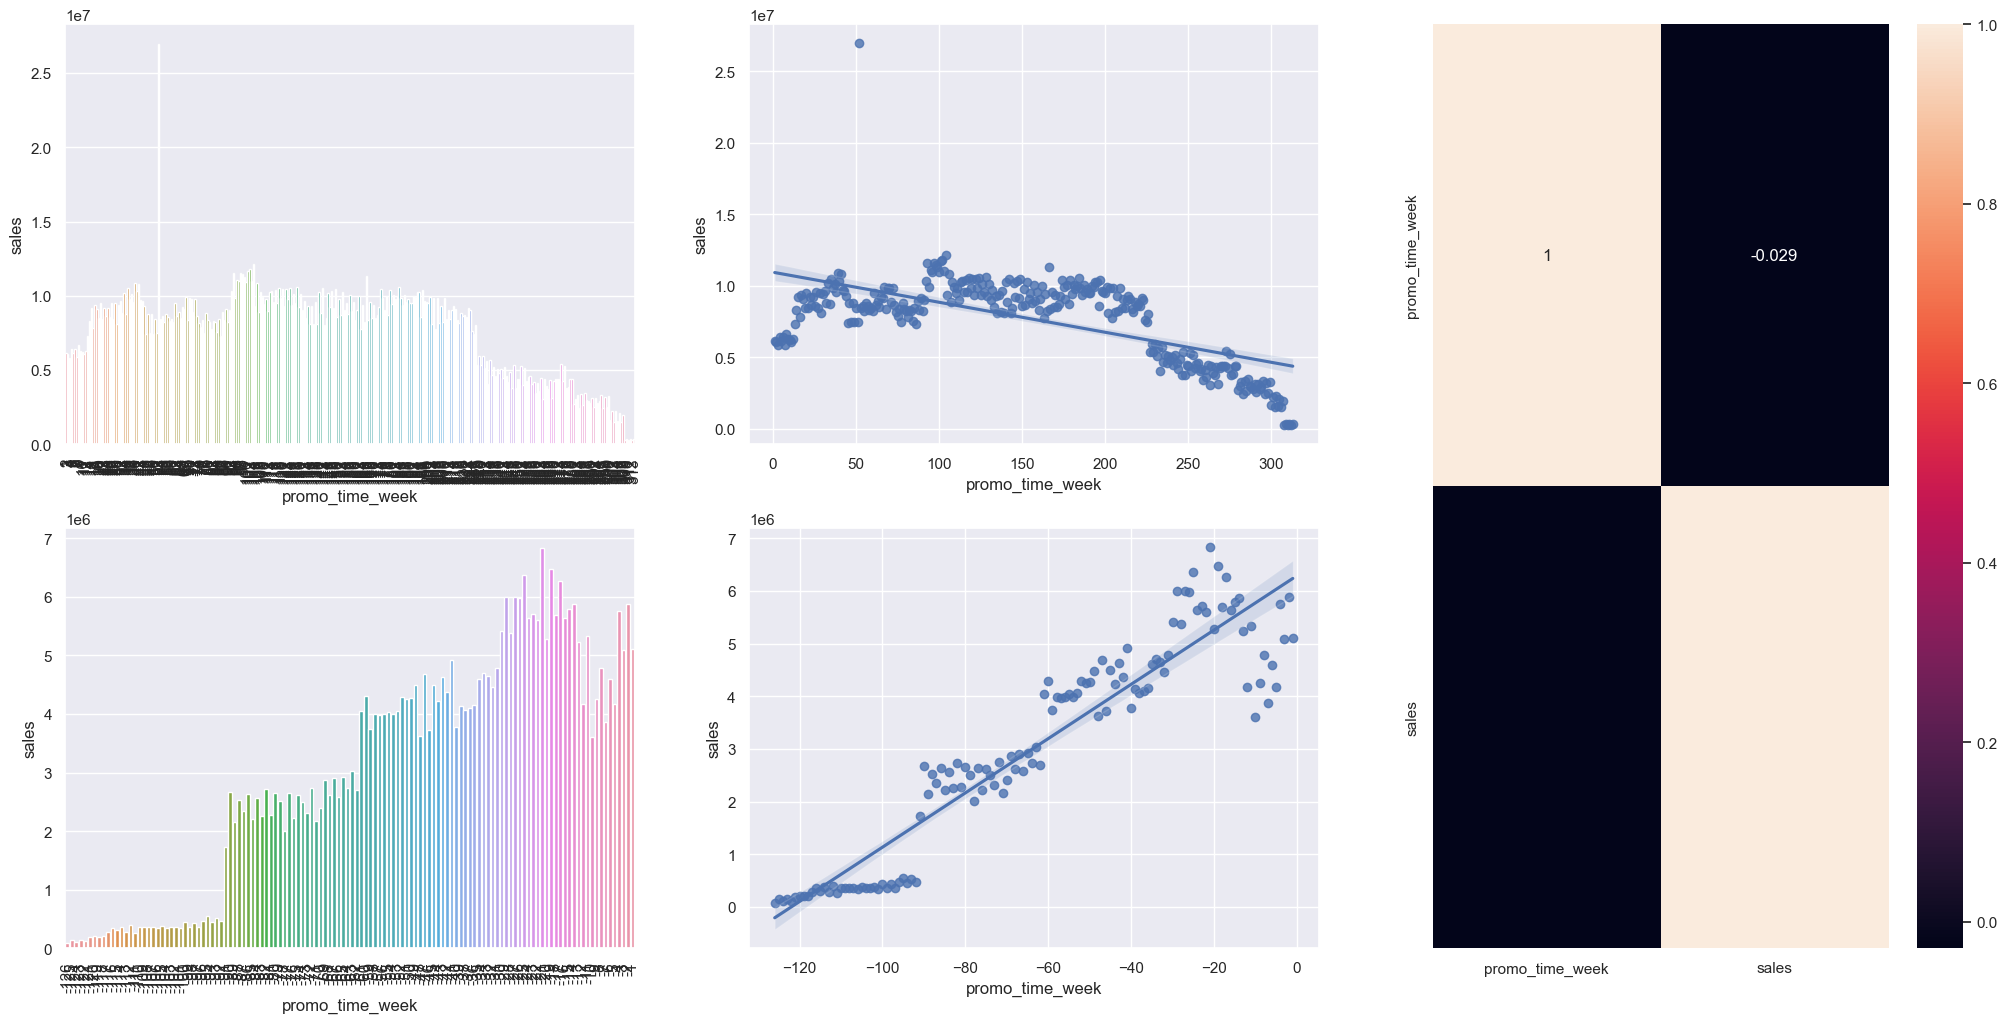

In [ ]:
#ERRADO!!!!!

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.5  Lojas com mais promoções consecutivas deveriam vender mais.

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


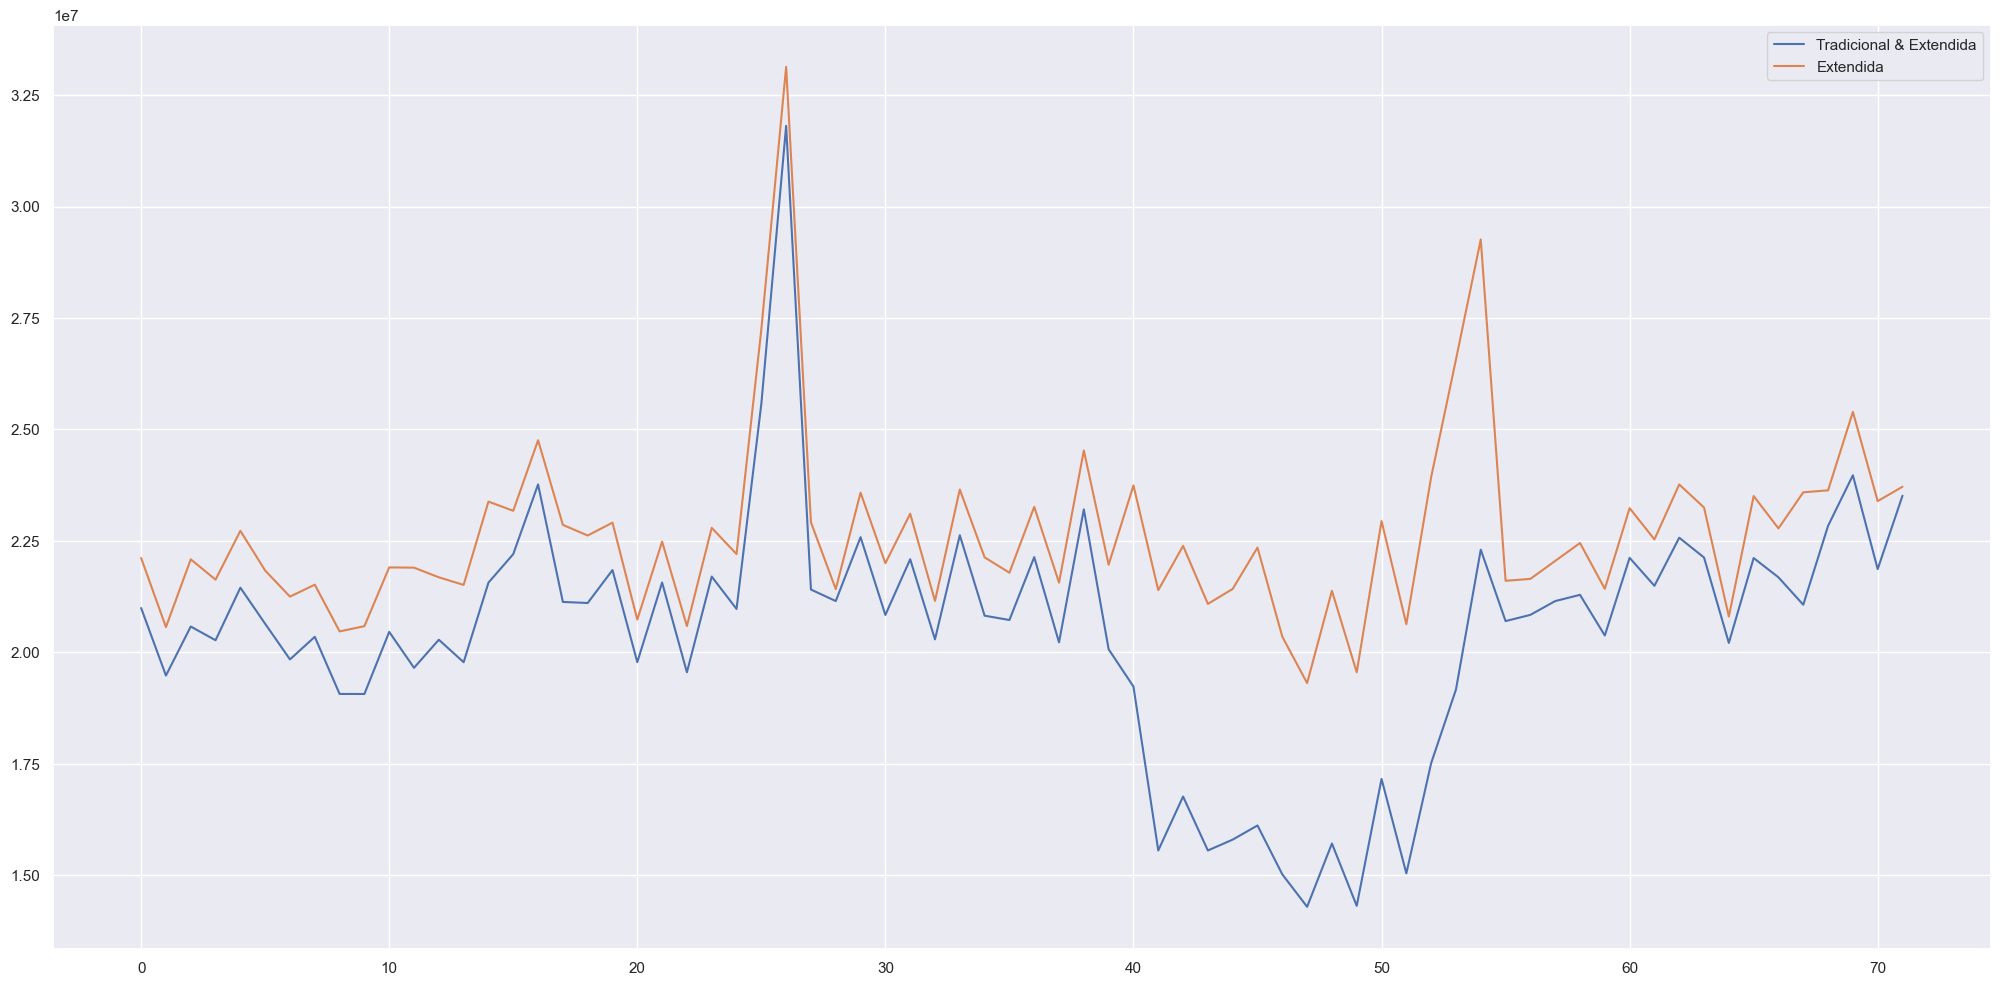

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

NameError: name 'df4' is not defined

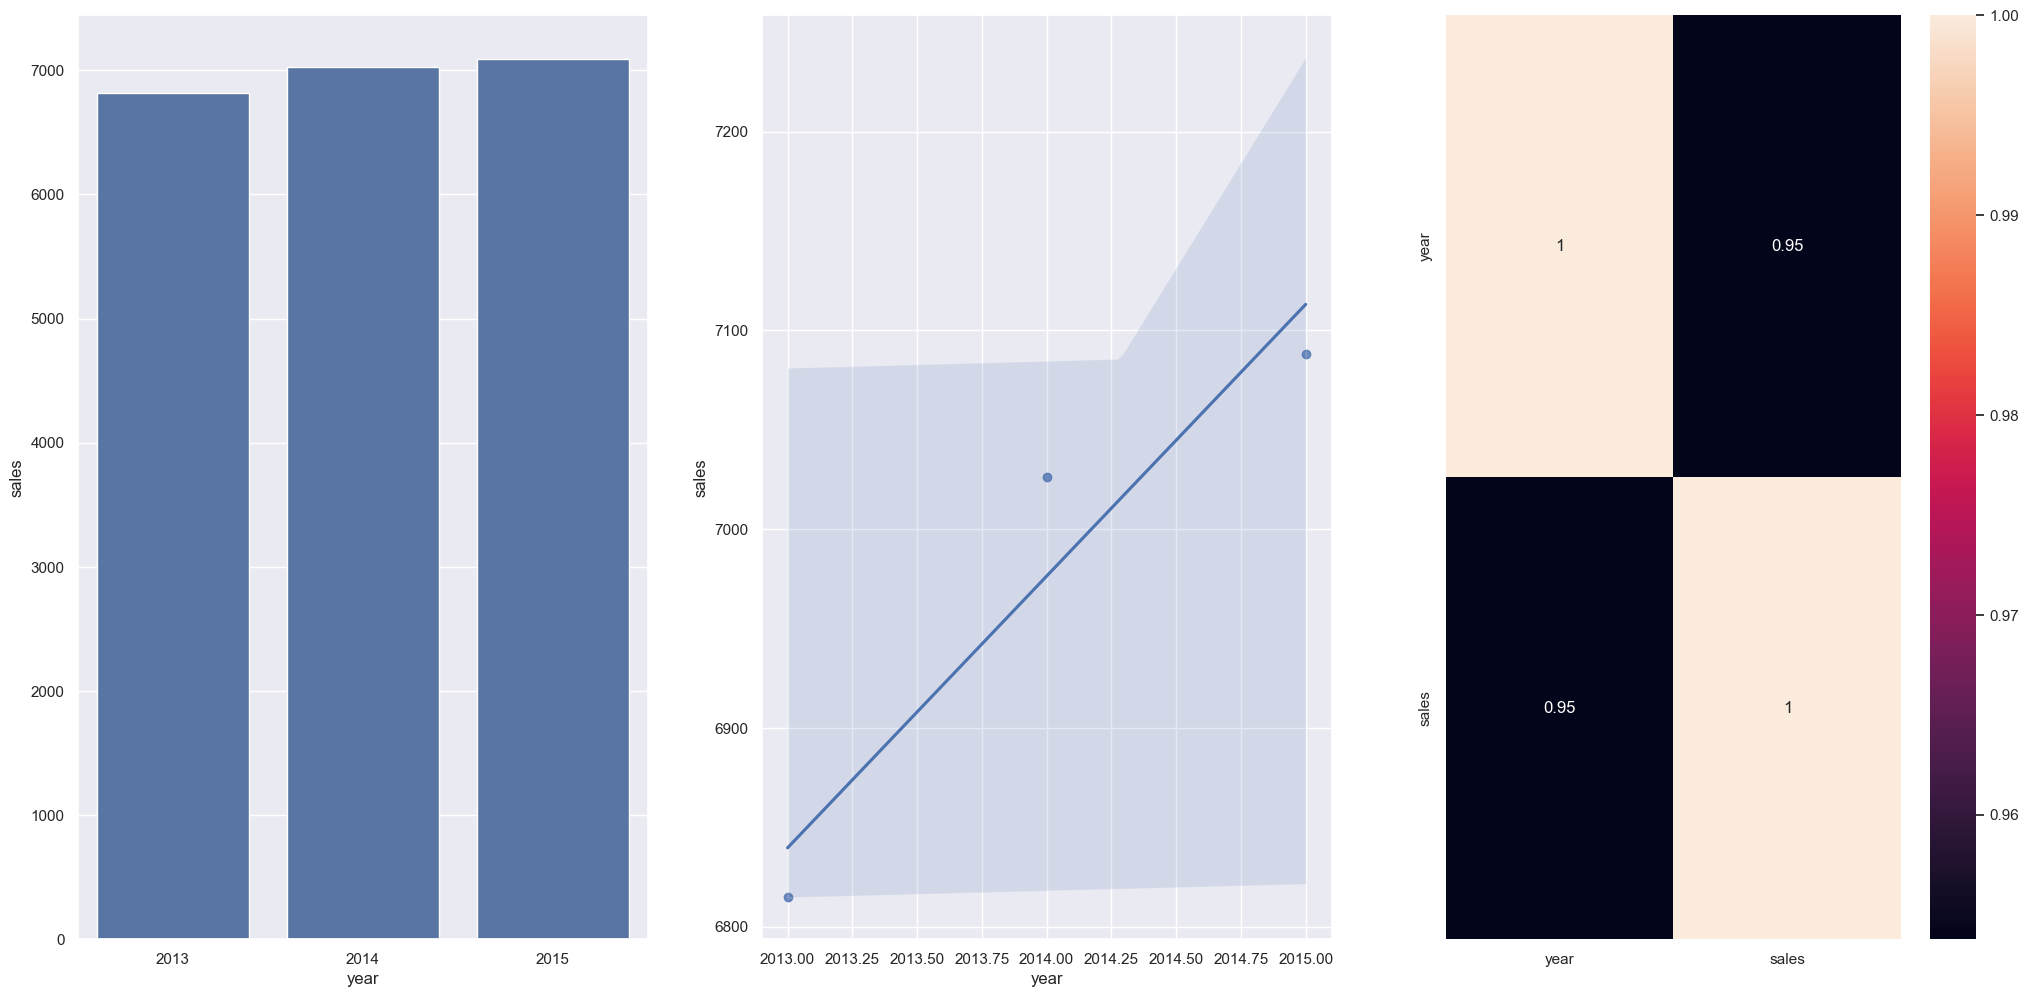

In [ ]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).mean().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# 5.0 Preparação dados

In [31]:
df5 = df4.copy()

## 5.1 Normalização - Nâo há dados para preparar - Não há distribuição normal nas variáveis numéricas

## 5.2 Rescaling
### Usado quando as variáveis númericas não tem distribuição normal

In [ ]:
df5.dtypes
df5['week_of_year'] = df5['week_of_year'].astype('float64')
var_numeric = df5.select_dtypes(include=['int32', 'int64', 'float64'])
var_numeric.head()


In [33]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)



## 5.3 Transformação

In [ ]:
df5.sample(30)

### 5.3.1 Encoding

In [ ]:
#state holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# store_type - labelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
df5.sample(15)


####### TESTANDO O TARGET ENCODER - DÁ UM VALOR COM BASE NO TOTAL DE SALES DE CADA TIPO DE LOJA
# from category_encoders import TargetEncoder
# te = TargetEncoder(cols=['store_type'])

# # Agora você pode usar a instância para codificar suas variáveis categóricas
# aux2['store_type'] = te.fit_transform(aux['store_type'], aux['sales'])
# aux2.sample(25)
###############################################

# assortment
assortment_dict = {'a': 1, 'b': 2, 'c': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.sample(25)


### 5.3.2 Response variable transformation

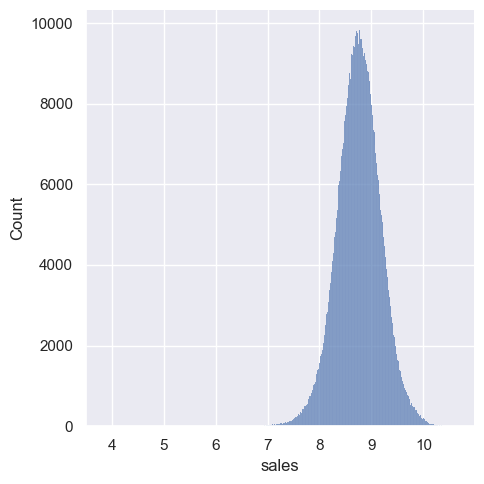

In [36]:
df5['sales'] = np.log1p(df5['sales'])
sns.displot(df5['sales'])

### 5.3.2 Nature Transformation

In [37]:

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7))).round(4)
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7))).round(4)


# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12))).round(4)
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12))).round(4)


# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30))).round(4)
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30))).round(4)

# week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52))).round(4)
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52))).round(4)




In [ ]:
df5.sample(10)

# 6.0 Feature selection

In [38]:
df6 = df5.copy()


## 6.1 Dividir df em treinamento e teste

In [ ]:
# retirar todas as colunas que não tem utilidade    
df6.head()
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)



In [47]:
df6.head()
# Usar 6 últimas semanas para teste

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
#encontrado a data 2015-06-19 como 6 últimas semanas para testes

Timestamp('2015-06-19 00:00:00')

In [108]:

# dataset de treinamento (todo o restante será de treinamento)
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset



# dataset de teste (com 6 semanas finais)
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


## 6.2 Usando Boruta

In [109]:
# Setando o dataset de teste e treinamento para o Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()


np.int = np.int32
np.float = np.float64
np.bool = np.bool_
# Definir RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# # Substituir np.int por int
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)


In [141]:

# cols_selected = boruta.support_.tolist() #cria as colunas selecionadas pelo boruta
# x_train_fs = x_train.drop(['date', 'sales'], axis=1) #tira as colunas date e sales do train
# cols_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list #mostra o nome das colunas selecionadas pelo boruta

# cols_not_boruta = list( np.setdiff1d(x_train_fs.columns, cols_boruta))

# o resultado está dentro dessa variável abaixo:
# columns to add
feat_to_add = ['sales', 'date']

cols_selected_boruta = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_cos',
        'week_of_year_sin',
]
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [180]:
#x_train e test sem sales e date:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [124]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result





,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression model

In [115]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.951027,0.292927,2672.564735


### 7.2.1 Linear Regression Model - Cross Validation

In [192]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.556 (+/-) 295.698,0.303 (+/-) 0.017,2953.409 (+/-) 467.925


## 7.3 Linear Regression regularized - LASSO

In [120]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.428005,0.288319,2693.042317


### 7.3.1 Linear Regression regularized (LASSO) - Cross Validation

In [197]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - LASSO', lrr, verbose=False)
lrr_result_cv

Kfold Number 5
Kfold Number 4


c:\Users\junic\OneDrive\Documentos\Comunidade DS\repos\ds_em_producao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e+01, tolerance: 1.194e+01
  


Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - LASSO,2088.304 (+/-) 325.215,0.296 (+/-) 0.013,2986.525 (+/-) 497.856


## 7.4 Random Forest Regressor

In [198]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=12, random_state=42).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.371483,0.099812,1009.625628


### 7.4.1 Random Forest Regressor - Cross Validation

In [199]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,839.895 (+/-) 219.082,0.116 (+/-) 0.023,1260.491 (+/-) 320.75


## 7.5 XGBoost Regressor

In [200]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=5000,
                            eta=0.01,
                            max_depth =10,
                            subsample=0.9,
                            colsample_bytree=0.9,
                            n_jobs=12, random_state=42).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,631.657472,0.091025,926.638095


### 7.5.1 XGBoost Regressor Cross Validation

In [204]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,823.527 (+/-) 145.093,0.115 (+/-) 0.012,1200.662 (+/-) 207.272


## 7.6 Compare Model´s Regressor Performance

In [137]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,631.657472,0.091025,926.638095
0,Random Forest Regressor,678.371483,0.099812,1009.625628
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.951027,0.292927,2672.564735
0,Linear Regression - Lasso,1869.428005,0.288319,2693.042317


### 7.6.1 Model´s Regressor Performance - Cross Validation

In [203]:
modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,823.527 (+/-) 145.093,0.115 (+/-) 0.012,1200.662 (+/-) 207.272
0,Random Forest,839.895 (+/-) 219.082,0.116 (+/-) 0.023,1260.491 (+/-) 320.75
0,Linear Regression,2082.556 (+/-) 295.698,0.303 (+/-) 0.017,2953.409 (+/-) 467.925
0,Linear Regression - LASSO,2088.304 (+/-) 325.215,0.296 (+/-) 0.013,2986.525 (+/-) 497.856


In [178]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Linear Regression', model)
a

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2063.022 (+/-) 293.652,0.299 (+/-) 0.011,2935.59 (+/-) 453.825
